# Run LDA on lyrics to categorise songs by lyrics

In [1]:
import json
from operator import index
import matplotlib.pyplot as plt
import re
import pandas as pd
plt.style.use('ggplot')

processed_song_df = pd.read_csv('../temp/phrase_fix_1.csv', index_col=0)
original_df = pd.read_csv('../temp/processed_song_df.csv', index_col=0)

## Use gensim LDA model as has coherence measure
based on following (large edits needed):
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [2]:
import gensim
from gensim.utils import simple_preprocess

# note this doesn't do anything as already processed lol
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = processed_song_df['0'].tolist()
data = [re.sub(r"endofparagraph", "", phrase) for phrase in data] # remove end of paragraph
data = [re.sub(r"endofline", "", phrase) for phrase in data] # remove end of phrase
data_words = list(sent_to_words(data)) # list of words, in list for each song


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])



# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomasdhome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Set up global variables

In [3]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(data_lemmatized[:1][0][:30])


import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]



## Basic LDA model

In [4]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=10, 
                                       random_state=100, chunksize=100, passes=10,
                                       per_word_topics=True)



from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score for basic LDA model: ', coherence_lda)


# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, 
                                           random_state=100, chunksize=100, passes=10,
                                           alpha=a, eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()




Coherence Score for basic LDA model:  0.5096857114471709


## Grid search for best model

In [5]:
lda_tuning_results = pd.read_csv('../results/lda_tuning_results.csv')

In [6]:
import numpy as np
import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
#                corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }



# Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     lda_tuning_results = pd.DataFrame(model_results)
#     lda_tuning_results.to_csv('./results/lda_tuning_results.csv', index=False)
#     pbar.close()


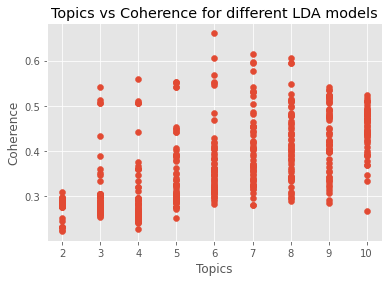

In [7]:
plt.scatter(lda_tuning_results['Topics'], lda_tuning_results['Coherence'])
plt.xlabel('Topics')
plt.ylabel('Coherence')
plt.title('Topics vs Coherence for different LDA models')
plt.show()

## Run champion LDA model that doesn't overfit

In [8]:
num_topics = 3
alpha = 0
beta = .91

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics, 
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        alpha=0.01,
                                        eta=0.91)

rows = []
for i in range(len(corpus)):
    arr = lda_model[corpus[i]]

    #calculate champ
    tuple_champ = (0,0)
    for categ_tuple in arr:
        categ, prob = categ_tuple
        if(prob>tuple_champ[1]): tuple_champ = categ_tuple
    
    rows.append({'categ': tuple_champ[0], 'p': tuple_champ[1]})

df = pd.DataFrame(rows)
df['song'] = original_df['song']
df.to_csv('../temp/lda_categ_song.csv')


## Visualise this model  
Note that the bubbles are well separated and coherence was high for this model (see excel file for exact value)

In [9]:
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('../results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '../results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.100620  0.032746       1        1  85.180465
2     -0.010816 -0.056800       2        1  12.656037
1      0.111436  0.024054       3        1   2.163498, topic_info=               Term         Freq        Total Category  logprob  loglift
13        endofline  2940.000000  2940.000000  Default  30.0000  30.0000
28             know   290.000000   290.000000  Default  29.0000  29.0000
14   endofparagraph   586.000000   586.000000  Default  28.0000  28.0000
166           never   135.000000   135.000000  Default  27.0000  27.0000
54             take    73.000000    73.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
44            right     1.030123    46.540847   Topic3  -5.7585   0.0228
28             know     1.016695   290.708239   Topic3  -5.7717  -1.8223
636        anywhere     0.646593     9.579772   Topic3  -6.2242   1.1378
14   endofparagraph     0.947898   586.810037   Topic3  -5.8417  -2.5948
46              run     0.684968    27.319102   Topic3  -6.1666   0.1475

[183 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
193       1  0.982545    always
193       2  0.021834    always
636       1  0.730706  anywhere
636       2  0.208773  anywhere
636       3  0.104387  anywhere
...     ...       ...       ...
669       1  0.326157     wreck
669       2  0.326157     wreck
669       3  0.652313     wreck
192       1  0.238623     young
192       2  0.715868     young

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])